# Application 1: visual area parcellation using the Bayesian model of retinotopy

In this notebook, we explore one potential application of our toolbox for automated segmentation of early visual areas. To do so, we will leverage a [Bayesian model of retinotopy](https://elifesciences.org/articles/40224), which combines anatomical priors with empirical observations to generate individual retinotopic maps and visual area boundaries. The model uses a retinotopic template (prior) and retinotopic maps derived from some minutes of fMRI data (observation) to produce individual-level maps and visual area segmentation. Here, we show that retinotopic maps predicted with our toolbox can replace empirically derived maps and can be used within this Bayesian framework for obtaining early visual area parcels.

We will perform the following steps:
1. Generate required files for the Bayesian model of retinotopy;
2. Run the Bayesian model of retinotopy to estimate visual area boundaries;
3. Prepare [manually drawn visual area labels](https://osf.io/gqnp8/) for comparisons;
4. Determine group differences in VMA and HVA;
5. Compare automatically derived segmentations using either the empirically estimated or the predicted retinotopic maps as observations with the manually determined segmentations;

## Import libraries and functions

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import sys
import os
import scipy
import os.path as osp
import h5py
import shutil
import seaborn as sns

sys.path.append('..')

from functions.visualization import retinotopic_map_plot
from deepRetinotopy_TheToolbox.utils.rois import ROI_WangParcelsPlusFovea as roi
from functions.datasets import RetinotopyData_training, RetinotopyData, RetinotopyData_logbar
from ipywidgets import interact, Dropdown
from functions.evaluation import roi_earlyvisualcortex, create_mask
from nibabel import gifti
from matplotlib import pyplot as plt

## 1. Generate a 'dummy' variance explained file to be used as the weight in the Bayesian model

To use the the Bayesian model of retinotopy, we will generate some 'dummmy' files to be used as the 'weight'. Specifically, we use the mean variance explained across all subjects used for model training as our proxy of data reliability. 

In [ ]:
path_to_hcp_freesurfer = '/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/'
## Region of interest used for training
final_mask_L_ROI, final_mask_R_ROI, index_L_mask, index_R_mask = roi(['ROI'])
## Early visual cortex
final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi_earlyvisualcortex(['ROI'])

variance_explained_maps_lh = []
variance_explained_maps_rh = []

list_of_subs = os.listdir(path_to_hcp_freesurfer)
devset = ['186949', '169747', '826353', '825048', '671855',
                    '751550', '318637', '131722', '137128', '706040'] 
testset = ['680957', '191841', '617748', '725751', '198653',
                         '191336', '572045', '601127', '644246', '157336']

# Remove the testset and devset subjects from the list of subjects
list_of_subs = [sub for sub in list_of_subs if sub not in devset and sub not in testset]
print('Number of subjects in the training set:', len(list_of_subs))


for subject_id in list_of_subs:
    for hemisphere in ['lh', 'rh']:
        # Load the retinotopic data
        ROI_masked, mask = create_mask(final_mask_L_ROI, final_mask_R_ROI, 
                               final_mask_L, final_mask_R, hemisphere)
        data = RetinotopyData(path_to_hcp_freesurfer, subject_id, hemisphere, 'polarAngle')
        data.apply_mask_to_maps(ROI_masked)
        if hemisphere == 'lh':
            variance_explained_maps_lh.append(data.variance_explained)
        else:
            variance_explained_maps_rh.append(data.variance_explained)


variance_explained_maps_rh = np.array(variance_explained_maps_rh)
variance_explained_maps_lh = np.array(variance_explained_maps_lh)

variance_explained_mean_lh = np.mean(variance_explained_maps_lh, axis=0)
variance_explained_mean_rh = np.mean(variance_explained_maps_rh, axis=0)

variance_explained_median_lh = np.median(variance_explained_maps_lh, axis=0)
variance_explained_median_rh = np.median(variance_explained_maps_rh, axis=0)

template_rh = nib.load(f'{path_to_hcp_freesurfer}100610/deepRetinotopy/' +
                        '100610.fs_empirical_polarAngle_rh_masked.func.gii')
template_lh = nib.load(f'{path_to_hcp_freesurfer}100610/deepRetinotopy/' +
                        '100610.fs_empirical_polarAngle_lh_masked.func.gii')


for dummy_weight in ['mean', 'ones',]:
    if dummy_weight == 'mean':   
        template_rh.agg_data()[:][final_mask_R_ROI == 1] = np.array(variance_explained_mean_rh[:]/100)
        template_lh.agg_data()[:][final_mask_L_ROI == 1] = np.array(variance_explained_mean_lh[:]/100)
    elif dummy_weight == 'ones':
        template_rh.agg_data()[:][final_mask_R_ROI == 1] = 1
        template_lh.agg_data()[:][final_mask_L_ROI == 1] = 1
        
    nib.save(template_rh, f'./{dummy_weight}_variance_explained.rh.func.gii')
    nib.save(template_lh, f'./{dummy_weight}_variance_explained.lh.func.gii')

Number of subjects in the training set: 161


Note that these files are in the 32k_fs_LR stantard space, which means we still need to resample these maps to each individual's native space.

In [ ]:
%%bash
ml connectomeworkbench/1.5.0

path_to_hcp_freesurfer=/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/
cd $path_to_hcp_freesurfer

for dirSub in *; do
    for hemisphere in lh rh; do
        if [ hemisphere == ""$hemisphere"" ]; then
            hemi="L"
        else
            hemi="R"
        fi
        for dummy_weight in mean ones; do
            wb_command -metric-resample /home/ribeiro/Projects/deepRetinotopy_validation/notebooks/"$dummy_weight"_variance_explained."$hemisphere".func.gii \
                    ../../templates/fs_LR-deformed_to-fsaverage."$hemi".sphere.32k_fs_LR.surf.gii \
                    $dirSub/surf/"$hemisphere".sphere.reg.surf.gii ADAP_BARY_AREA "$dirSub"/deepRetinotopy/"$dirSub"."$dummy_weight"_variance_explained."$hemisphere".native.func.gii \
                    -area-surfs $dirSub/surf/"$dirSub"."$hemisphere".midthickness.32k_fs_LR.surf.gii "$dirSub"/surf/"$hemisphere".midthickness.surf.gii
        done
    done
done

## 2. Generate visual area labels using the Bayesian model of retinotopy

First, we will rename files and transform polar angle maps to the required Neuropythy convention (LH: 0-180 referring to UVM -> RHM -> LVM). 

In [ ]:
%%bash

cd ../scripts/segmentations
freesurfer_subjects_dir=/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer
path_to_validation_repo=/home/ribeiro/Projects/deepRetinotopy_validation/
# rename files
# bash hcp_rename_model_files.sh -s $freesurfer_subjects_dir
# transform polar angle maps
bash hcp_neuropythy_transforms.sh -s $freesurfer_subjects_dir -r $path_to_validation_repo

Now, we can estimate visual area boundaries using register_retinotopy model. To do it, we need to first set up the ~/.npythyrc configuration file (see [documentation](https://github.com/noahbenson/neuropythy)) with appropriate paths:

```
{"freesurfer_subject_paths": "/PATH_TO_FREESURFER_DATA",
 "data_cache_root":          "~/tmp/npythy_cache",
 "hcp_subject_paths":        "",
 "hcp_auto_download":        true,
 "hcp_credentials":          ""}
```

Additionally, make sure each subject folder contain all freesurfer dirs, i.e., 

```
.
├── label
├── mri
├── scripts
├── stats
├── surf
└── touch
```

Then we can run the following bash script that will perform all the required steps. But, before running the cell below, make sure you activate an environment with neuropythy available.

In [2]:
import os
from multiprocessing import Pool

def process_subject(args):
    """Process a single subject in its own screen session."""
    subject, dataset_path = args
    screen_name = f'neuropythy-{subject}'
    command = f'screen -S {screen_name} -dm bash -c "source ~/miniforge3/etc/profile.d/conda.sh && conda activate neuropythy && python ../scripts/segmentations/hcp_neuropythy_execute.py --execute --subjects_dir {dataset_path} --subject_id {subject}"'
    result = os.system(command)
    return result

def run_neuropythy_parallel(dataset_path=None, subjects_list=None, num_cores=4):
    """
    Run neuropythy processing in parallel using screen sessions.
    
    Args:
        dataset_path (str): Path to dataset
        subjects_list (list): List of subject IDs  
        num_cores (int): Number of parallel processes (default: 4)
    """
    if not os.path.exists(dataset_path):
        print('Dataset path does not exist.')
        return
    
    if subjects_list is None:
        # Original single command for all subjects
        os.system(f'screen -S neuropythy-all -dm python ../scripts/segmentations/hcp_neuropythy_execute.py --execute --subjects_dir {dataset_path}')
        print("Started processing all subjects in screen session 'neuropythy-all'")
        return
    
    # Prepare arguments for parallel processing
    args_list = [(subject, dataset_path) for subject in subjects_list]
    
    # Run in parallel - each subject gets its own screen session
    with Pool(processes=num_cores) as pool:
        pool.map(process_subject, args_list)
    
    print(f"Started {len(subjects_list)} screen sessions (launching {num_cores} at a time)")
    print("Use 'screen -ls' to see all sessions")
    print("Use 'screen -r neuropythy-<subject_id>' to attach to a specific session")

In [3]:
path_to_hcp_freesurfer = '/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/'
# list only subjects within the testset and devset
subjects = ['186949', '169747', '826353', '825048', '671855',
                '751550', '318637', '131722', '137128', '706040', 
                '680957', '191841', '617748', '725751', '198653',
                '191336', '572045', '601127', '644246', '157336']

run_neuropythy_parallel(
    dataset_path=path_to_hcp_freesurfer,
    subjects_list=subjects,
    num_cores=12 
)

Started 20 screen sessions (launching 12 at a time)
Use 'screen -ls' to see all sessions
Use 'screen -r neuropythy-<subject_id>' to attach to a specific session


Finally, we can convert the generated files to .gii files.

In [4]:
def convert_to_gii(dataset_path=None, subject=None,):
    screen_name=f'convert_to_gii_{subject}'
    command = f'screen -S {screen_name} -dm bash ../scripts/segmentations/hcp_create_gii.sh -s {dataset_path} -i {subject}'
    result = os.system(command)
    return result

for subject in subjects:
    convert_to_gii(path_to_hcp_freesurfer, subject)

## 3. Organize manual labels for comparisons

To test the validity of our automated pipeline for visual area segmentation, we will compare the generated visual area labels with manual labels drawn by four anatomists. This data is available on [OSF](https://osf.io/gqnp8/). In the 'Files' tab in the OSF page, you need to download the A1, A2, A3, and A4 data folders available in the 'normalised' directory. 

In [10]:
# variables and placeholder for files
label_files = []
subjects = []
path_to_files = "/home/ribeiro/Projects/deepRetinotopy_validation/HCP/"
anatomists = ["A1", "A2", "A3", "A4"]
hemisphere = ['lh', 'rh']


# create an array with all the file names containing ".labels.hdf5"
path_to_sub = ("{path_to_files}/{anatom}").format(path_to_files=path_to_files, anatom=anatomists[0])
for files in os.listdir(path_to_sub):
    if files.endswith("labels.hdf5"):
        # append all files with ".labels.hdf5" from A1
        label_files.append(files)
        # if they are not in one of the other anatomists, the file will be removed
        for anatom in anatomists:
            path_to_file = ("{path_to_files}/{anatom}/{files}").format(path_to_files=path_to_files, anatom=anatom, files=files)
            if not os.path.isfile(path_to_file):
                if files in label_files:
                    label_files.remove(files)


# create a folder for all subjects and their files containing the maps from every anatomist
new_dir = ("{path_to_files}/subjects").format(path_to_files=path_to_files)
if not os.path.exists(new_dir):
    os.makedirs(new_dir)


# create a new array to have the subject names without the whole file name
for files in label_files:
    sub = files[:-12]
    subjects.append(sub)

print(f'Number of subjects with all files from all anatomists: {len(subjects)}')


# save all subjects where all data is correct
valid_subjects = []
maps = {}
for sub in subjects:
    # boolean to see if it worked
    is_valid = True

    # create a folder for every subject
    SUBJECTS_DIR = ("{new_dir}/{sub}").format(new_dir=new_dir, sub=sub)
    if not os.path.exists(SUBJECTS_DIR):
        os.makedirs(SUBJECTS_DIR)
    

    # create the maps from ".labels.hdf5" files
    for anatom in anatomists:
        path = ("{path_to_files}/{anatom}/{sub}.labels.hdf5").format(path_to_files=path_to_files, anatom=anatom, sub=sub)
        f = h5py.File(path, 'r')
        for hemi in hemisphere:
            # put all maps into the dictionary maps and save all maps in the SUBJECTS_DIR
            try:
                with h5py.File(path, 'r') as f:
                    # if 'lh' or 'visual_area' is not in the file, the error will be saved and the files and the subject itself will be removed
                    if hemi not in f:
                        txt = f"{path_to_files}/log.txt"
                        with open(txt, "a") as text:
                            text.write(f"{hemi} is missing in: {path}\n")
                        is_valid = False
                        break
                    if 'visual_area' not in f[hemi]:
                        txt = f"{path_to_files}/log.txt"
                        with open(txt, "a") as text:
                            text.write(f"'visual_area' is missing in: {path}\n")
                        is_valid = False
                        break

                            
                    # load the maps
                    curr_map = f[hemi]['visual_area']
                    curr_map = np.array(curr_map)
                    
                    # create the dictionary with the maps
                    if sub not in maps:
                        maps[sub] = {anatom: {hemi: [] for hemi in hemisphere} for anatom in anatomists}
                    maps[sub][anatom][hemi] = curr_map
                    #print(maps[sub][anatom][hemi])
                    path_to_save = (f"{SUBJECTS_DIR}/{anatom}.{hemi}.visual_area.gii")
                    gii_data = nib.gifti.GiftiDataArray(data=curr_map)
                    gii_img = nib.gifti.GiftiImage(darrays=[gii_data])
                    nib.save(gii_img, path_to_save)

            # if it cannot open the file it will be reported
            except Exception as e:
                #print(f"Can't open file {path}: {e}")
                txt = f"{path_to_files}/log.txt"
                with open(txt, "a") as text:
                    text.write(f"Can't open file {path}\n")
                is_valid = False
                break
        if not is_valid:
            break
    if not is_valid:
        if os.path.exists(SUBJECTS_DIR):
            shutil.rmtree(SUBJECTS_DIR)
        if sub in maps:
            del maps[sub]
    else:
        valid_subjects.append(sub)
subjects = valid_subjects

assert len(subjects) == len(maps)

Number of subjects with all files from all anatomists: 179


## 4. Comparing segmentations

In [5]:
# Functions
def calc_dice_score(array1, array2, mask):
    # Ensure all inputs are numpy arrays
    array1 = np.asarray(array1)
    array2 = np.asarray(array2)
    mask = np.asarray(mask)
    
    # calculate the intersection
    a1 = array1[mask == 1]
    a2 = array2[mask == 1]
    
    intersection = np.sum((a1 == 1) & (a2 == 1))
    size1 = np.sum(a1 == 1)
    size2 = np.sum(a2 == 1)
    
    if size1 + size2 == 0:
        return 0.0
    
    return 2 * intersection / (size1 + size2)

def create_dataframe_automated_vs_manual(dice_empirical, dice_deepret):
    data = []
    groups = ["empirical", "deepRetinotopy"]
    anatomists = ["A1", "A2", "A3", "A4"]
    hemisphere = ['lh', 'rh']
    vareas = [1, 2, 3]
    for hemi in hemisphere:
        for area in vareas:
            for sub in subjects:
                for anatom in anatomists:
                        for group in groups:
                            if group == "empirical":
                                value = dice_empirical[hemi][area][sub][anatom]
                            else:
                                value = dice_deepret[hemi][area][sub][anatom]
                            data.append({
                                'hemisphere': hemi,
                                'group': group,
                                'area': area,
                                'dice_score': value,
                                'subject': sub,
                                'anatomist': anatom
                            })
    return pd.DataFrame(data)

def create_dataframe_manual_vs_manual(dice_anatomist_anotimist):
    data_anatomist = []
    anatomists = ["A1", "A2", "A3", "A4"]
    hemisphere = ['lh', 'rh']
    vareas = [1, 2, 3]
    for hemi in hemisphere:
        for area in vareas:
            for sub in subjects:
                for anatom in anatomists:
                    value = dice_anatomist_anotimist[hemi][area][sub][anatom]
                    data_anatomist.append({
                        'hemisphere': hemi,
                        'area': area,
                        'dice_score': value,
                        'subject': sub,
                        'anatomist': anatom
                    })
    return pd.DataFrame(data_anatomist)

In [8]:
# list all subjects
subjects = []
path_to_files = "/home/ribeiro/Projects/deepRetinotopy_validation/HCP/"
path_to_subjects = "{path_to_files}/subjects".format(path_to_files=path_to_files)

# list only subjects within the testset and devset
subjects = ['186949', '169747', '826353', '825048', '671855',
            '751550', '318637', '131722', '137128', '706040', 
            '680957', '191841', '617748', '725751', '198653',
            '191336', '572045', '601127', '644246', '157336']

for sub in subjects:
    if not os.path.exists(f"{path_to_subjects}/{sub}"):
        subjects.remove(sub)
print(f'Number of subjects before removing missing files: {len(subjects)}')

# remove subjects with missing anatomist files
for sub in subjects:
    if not os.path.isfile(f"{path_to_files}/A1/{sub}.labels.hdf5") or \
                not os.path.isfile(f"{path_to_files}/A2/{sub}.labels.hdf5") or \
                not os.path.isfile(f"{path_to_files}/A3/{sub}.labels.hdf5") or \
                not os.path.isfile(f"{path_to_files}/A4/{sub}.labels.hdf5"):
        if sub in subjects:
            subjects.remove(sub)
print(f'Number of subjects used for evaluation: {len(subjects)}')

np.set_printoptions(threshold=1000)

groups = ["empirical", "deepRetinotopy"]
anatomists = ["A1", "A2", "A3", "A4"]
hemisphere = ['lh', 'rh']
vareas = [1, 2, 3]

# define dictionarys for the maps
maps_anatomists = {sub: {hemi: {anatom: [] for anatom in anatomists} for hemi in hemisphere} for sub in subjects}
maps_groups = {sub: {hemi: {group: [] for group in groups} for hemi in hemisphere} for sub in subjects}
# define dictionarys for the visual area maps
mask_varea_anatomists = {sub: {hemi: {area: {anatom: [] for anatom in anatomists} for area in vareas} for hemi in hemisphere} for sub in subjects}
mask_varea_groups = {sub: {hemi: {area: {group: [] for group in groups} for area in vareas} for hemi in hemisphere} for sub in subjects}
# define dictionary for the mask of the manually derived labels
mask = {sub: {hemi: [] for hemi in hemisphere} for sub in subjects}
# define dictionary for the dice score
dice_empirical = {hemi: {area: {sub: {anatom: [] for anatom in anatomists} for sub in subjects} for area in vareas} for hemi in hemisphere}
dice_deepret = {hemi: {area: {sub: {anatom: [] for anatom in anatomists} for sub in subjects} for area in vareas} for hemi in hemisphere}
dice_empirical_deepret = {hemi: {area: {sub: 0 for sub in subjects} for area in vareas} for hemi in hemisphere}
dice_anatomist_anotimist = {hemi: {area: {sub: {anatom: [] for anatom in anatomists} for sub in subjects} for area in vareas} for hemi in hemisphere}

for sub in subjects:
    print(f'Computing dice scores for subject {sub}')
    for hemi in hemisphere:
        # load the dictionarys for the anatomists
        for anatom in anatomists:
            path = "{path_to_subjects}/{sub}/{anatom}.{hemi}.visual_area.gii".format(path_to_subjects=path_to_subjects, sub=sub, anatom=anatom, hemi=hemi)
            array = nib.load(path)
            array = array.agg_data()
            maps_anatomists[sub][hemi][anatom] = array
            
        mask[sub][hemi] = (~np.all([arr == 0 for arr in maps_anatomists[sub][hemi].values()], axis=0)).astype(int)
        
        # load the dictionarys for empirical and deepRetinotopy data
        for group in groups:
            path = f"{path_to_files}/freesurfer/{sub}/deepRetinotopy/inferred_{group}/{hemi}.inferred_varea.gii".format(path_to_files=path_to_files, sub=sub, group=group, hemi=hemi) # TODO: update
            array = nib.load(path)
            array = array.agg_data()
            maps_groups[sub][hemi][group] = array                

        
        # calculate the dice score for deepRetinotopy against the four anatomists
        for area in vareas:
            for group in groups:
                # create the maps for the different visual areas
                array = maps_groups[sub][hemi][group]
                mask_varea_groups[sub][hemi][area][group] = (array == area).astype(int)
            
            for anatom in anatomists:
                # create the maps for the different visual areas
                array = maps_anatomists[sub][hemi][anatom]
                mask_varea_anatomists[sub][hemi][area][anatom] = (array == area).astype(int)

                # dice score - automated vs manual
                m1 = mask_varea_groups[sub][hemi][area]["empirical"]
                m2 = mask_varea_anatomists[sub][hemi][area][anatom]
                assert m1.shape == m2.shape
                dice = calc_dice_score(m1, m2, mask[sub][hemi])
                dice_empirical[hemi][area][sub][anatom] = dice
                
                m1 = mask_varea_groups[sub][hemi][area]["deepRetinotopy"]
                m2 = mask_varea_anatomists[sub][hemi][area][anatom]
                assert m1.shape == m2.shape
                dice = calc_dice_score(m1, m2, mask[sub][hemi])
                dice_deepret[hemi][area][sub][anatom] = dice

                tmp_anatomist_vs_anatomist = []
                for anatom2 in anatomists:
                    # dice score - manual vs manual
                    if anatom != anatom2:
                        m1 = mask_varea_anatomists[sub][hemi][area][anatom]
                        array = maps_anatomists[sub][hemi][anatom2]
                        mask_varea_anatomists[sub][hemi][area][anatom2] = (array == area).astype(int)
                        m2 = mask_varea_anatomists[sub][hemi][area][anatom2]
                        
                        assert m1.shape == m2.shape

                        dice = calc_dice_score(m1, m2, mask[sub][hemi])
                        tmp_anatomist_vs_anatomist.append(dice)
                    dice_anatomist_anotimist[hemi][area][sub][anatom] = np.mean(tmp_anatomist_vs_anatomist)

            m1 = mask_varea_groups[sub][hemi][area]["empirical"]
            m2 = mask_varea_groups[sub][hemi][area]["deepRetinotopy"]
            dice = calc_dice_score(m1, m2, mask[sub][hemi])
            dice_empirical_deepret[hemi][area][sub] = dice

df_automated_vs_manual = create_dataframe_automated_vs_manual(dice_empirical, dice_deepret)
df_anatomists = create_dataframe_manual_vs_manual(dice_anatomist_anotimist)

Number of subjects before removing missing files: 16
Number of subjects used for evaluation: 8
Computing dice scores for subject 826353
Computing dice scores for subject 671855
Computing dice scores for subject 318637


/home/ribeiro/miniforge3/envs/deepretinotopy_validation/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ribeiro/miniforge3/envs/deepretinotopy_validation/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Computing dice scores for subject 706040
Computing dice scores for subject 191841
Computing dice scores for subject 725751
Computing dice scores for subject 191336


Computing dice scores for subject 157336


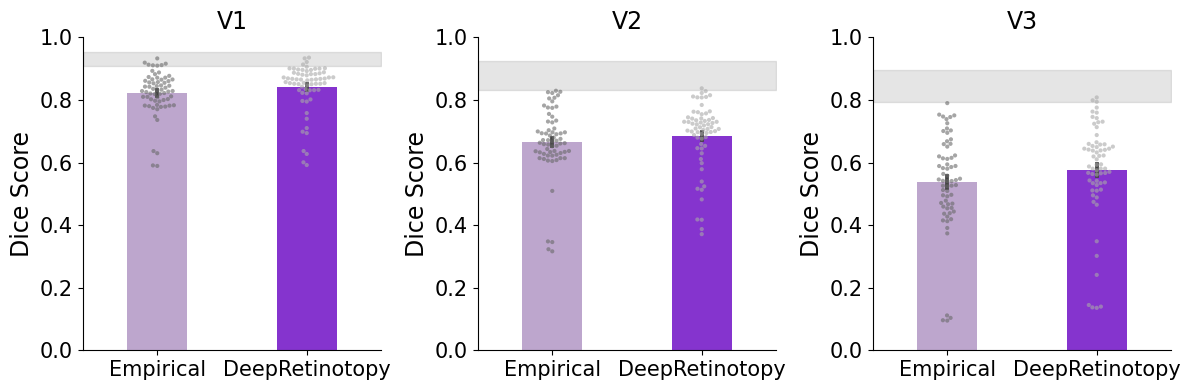

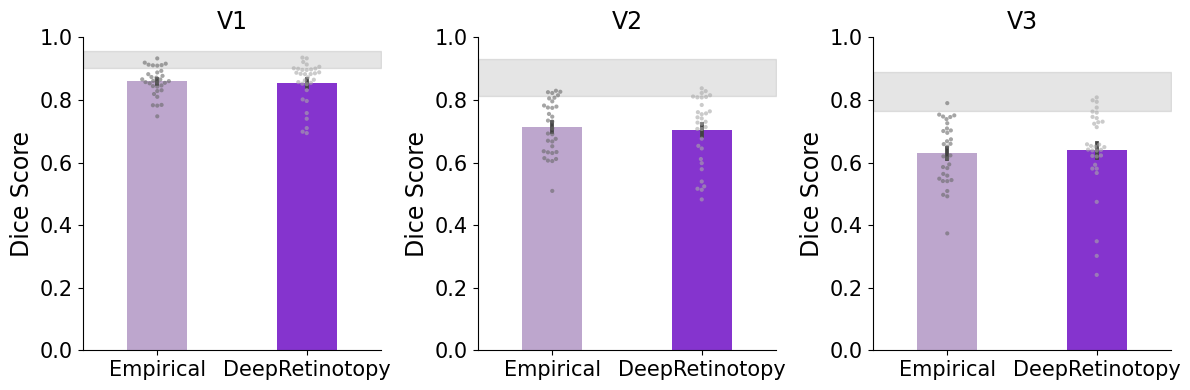

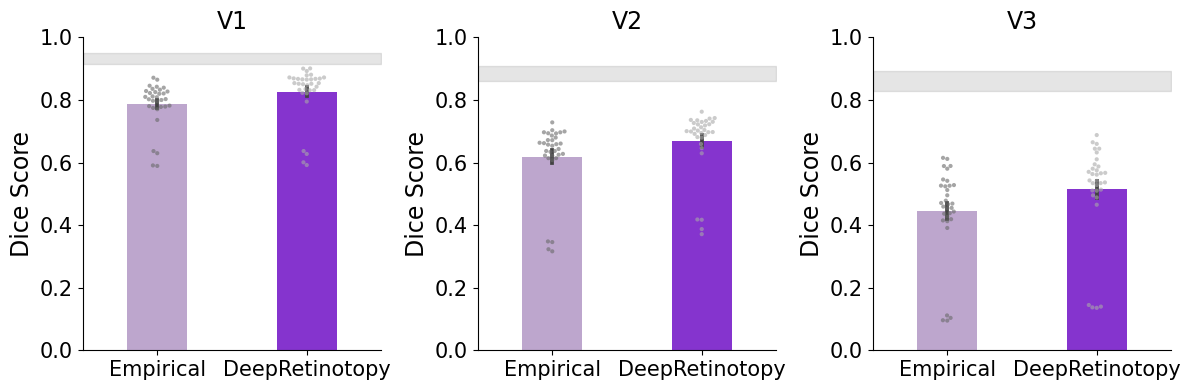

In [9]:
# Barplots of dice scores
def create_barplots(df_automated_vs_manual, df_anatomists, hemisphere = 'both'):
    output_dir = './../output/segmentation/'
    if os.path.exists(output_dir) is False:
            os.makedirs(output_dir)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, area in enumerate(vareas):
        plt.sca(axes[i])

        if hemisphere == 'both':
            # automated vs manual
            results_method = df_automated_vs_manual[(df_automated_vs_manual['area'] == area)]
            # manual
            mean_anatomist = df_anatomists[(df_anatomists['area'] == area)]['dice_score'].mean()
            std_anatomist = df_anatomists[(df_anatomists['area'] == area)]['dice_score'].std()
        else:
            # automated vs manual
            results_method = df_automated_vs_manual[(df_automated_vs_manual['area'] == area) & (df_automated_vs_manual['hemisphere'] == hemisphere)] 
            # manual
            mean_anatomist = df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['hemisphere'] == hemisphere)]['dice_score'].mean()
            std_anatomist = df_anatomists[(df_anatomists['area'] == area) & (df_anatomists['hemisphere'] == hemisphere)]['dice_score'].std()
        
        sns.barplot(data=results_method, y='dice_score', x="group", errorbar='se', ax=axes[i], palette=['#bea0d3ff', '#861ae8ff'], linewidth= 3, width=0.4)
        sns.swarmplot(data=results_method, y='dice_score', x="group", palette=['dimgray','darkgray'], hue='group', size=3, ax=axes[i], alpha=0.6)
        axes[i].set_title(f'V{area}', fontsize=17)
        axes[i].set_ylim(0, 1)
        axes[i].legend_.remove() 

        plt.fill_between([-0.5, 1.5], mean_anatomist - std_anatomist, mean_anatomist + std_anatomist, alpha=0.2, color='gray')
        plt.ylabel("Dice Score", fontsize=17)
        plt.xlabel("")
        plt.xticks([0, 1], ['Empirical', 'DeepRetinotopy'], fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlim(-0.5, 1.5)
        plt.ylim(0, 1) 
        plt.tight_layout()
        sns.despine()
        plt.savefig(f'{output_dir}dice_score_across_visual_areas_{hemisphere}.pdf', dpi=300)
    return plt.show()

for hemisphere in ['both', 'lh', 'rh']:
    create_barplots(df_automated_vs_manual, df_anatomists, hemisphere = hemisphere)
